In [1]:
import torch
import random
from torchinfo import summary
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import ConcatDataset, DataLoader, Subset
from tqdm import tqdm
from config import Config
from data_loader import *
from model import CRNN
from train import Trainer
from utils import *
from torch.nn import CTCLoss
from augmentation import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
config = Config()
random.seed(42)
np.random.seed(0)
# torch.backends.nnpack.enabled = False

In [3]:
# Загрузка данных
train_transforms = get_augmented_transforms(config.input_size)
val_transforms = get_transforms(config.input_size)

cyrillic_train = CyrillicDataset(
    root='Datasets/Cyrillic/train',
    tsv_path='Datasets/Cyrillic/train.tsv',
    transform=val_transforms)

cyrillic_test = CyrillicDataset(
    root='Datasets/Cyrillic/test',
    tsv_path='Datasets/Cyrillic/test.tsv',
    transform=val_transforms)

mine = MineDataset(
    root='Datasets/Mine/img',
    tsv_path='Datasets/Mine/train.tsv',
    transform=train_transforms)

mine_aug = MineDataset(
    root='Datasets/Mine/augs',
    tsv_path='Datasets/Mine/augs.tsv',
    transform=None)

hkr_train = HKRDataset(
    img_dir='Datasets/HKR/img',
    ann_dir='Datasets/HKR/ann',
    transform=val_transforms)

In [4]:
cyrillic_train_set = random.sample(range(len(cyrillic_train)), 5000)
# cyrillic_test_set = random.sample(range(len(cyrillic_test)), 1000)
hrk_set = random.sample(range(len(hkr_train)), 5000)

In [5]:
cyrillic_train_val_indices = list(set(range(len(cyrillic_train))) - set(cyrillic_train_set))
# cyrillic_test_val_indices = list(set(range(len(cyrillic_test))) - set(cyrillic_test_set))
hrk_val_indices = list(set(range(len(hkr_train))) - set(hrk_set))

train_set = ConcatDataset([
    Subset(cyrillic_train, cyrillic_train_set),
    # Subset(cyrillic_test, cyrillic_test_set),
    Subset(hkr_train, hrk_set),
    # mine_aug,
    mine
])

cyrillic_val_set = random.sample(range(len(cyrillic_train_val_indices)), 4000)
cyrillic_test_set = random.sample(range(len(cyrillic_test)), 1000)
hrk_val_set = random.sample(range(len(hrk_val_indices)), 5000)

val_set = ConcatDataset([
    Subset(cyrillic_train, cyrillic_val_set),
    Subset(cyrillic_test, cyrillic_test_set),
    Subset(hkr_train, hrk_val_set),
])

In [6]:
# # Объединение датасетов
# full_dataset = ConcatDataset([cyrillic_train, cyrillic_test, hkr_train])
# train_size = int(config.train_ratio * len(full_dataset))
# val_size = len(full_dataset) - train_size
# train_set, val_set = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# train_set = ConcatDataset([train_set, mine])

In [7]:
# train_set = AugmentedDataset(train_set, val_transforms)

# val_set = AugmentedDataset(val_set, val_transforms)

In [8]:
len(train_set)

11017

In [9]:
train_set[5000]

(tensor([[[0.9922, 0.9922, 0.9922,  ..., 1.0000, 0.9843, 0.9843],
          [0.9922, 0.9922, 0.9922,  ..., 1.0000, 0.9922, 0.9922],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.9922, 0.9922, 1.0000,  ..., 0.9922, 0.9922, 0.9922],
          [0.9922, 0.9922, 0.9922,  ..., 0.9686, 0.9608, 0.9529],
          [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9843, 0.9922]]]),
 'прекрасно в нас')

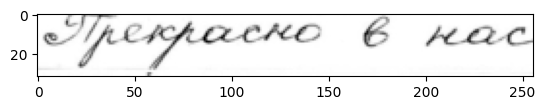

In [10]:
image_numpy = np.transpose(train_set[5000][0].numpy(), (1, 2, 0))
# Отобразите изображение
plt.imshow(image_numpy,cmap='gray')
plt.show()

In [11]:
len(val_set)

10000

In [12]:
val_set[10]

(tensor([[[0.3961, 0.4039, 0.3569,  ..., 0.3569, 0.2863, 0.0980],
          [0.3882, 0.4196, 0.3804,  ..., 0.3725, 0.2941, 0.1529],
          [0.3725, 0.4039, 0.4275,  ..., 0.3255, 0.2627, 0.1686],
          ...,
          [0.1843, 0.1922, 0.1922,  ..., 0.1529, 0.1765, 0.0588],
          [0.3725, 0.3725, 0.3490,  ..., 0.2078, 0.2706, 0.2157],
          [0.3490, 0.3490, 0.3412,  ..., 0.3020, 0.3020, 0.2235]]]),
 'применение')

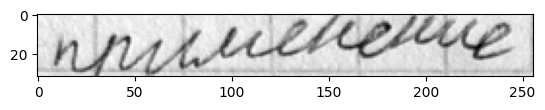

In [13]:
image_numpy = np.transpose(val_set[10][0].numpy(), (1, 2, 0))
# Отобразите изображение
plt.imshow(image_numpy,cmap='gray')
plt.show()

In [14]:
train_loader = DataLoader(train_set, batch_size=config.batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=config.batch_size, num_workers=4)

In [15]:
# Инициализация модели
model = CRNN(config)
optimizer = Adam(model.parameters(), lr=config.lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', min_lr=0.0000001, factor=0.5, patience=3)

In [16]:
test_input = torch.randn(128, 1, 32, 256)  # Пример входа: [Batch Size, Channels, Height, Width]

# Использование torchinfo для отображения информации о модели
summary(model, input_data=test_input)

Layer (type:depth-idx)                   Output Shape              Param #
CRNN                                     [64, 128, 50]             --
├─Sequential: 1-1                        [128, 256, 1, 64]         --
│    └─Conv2d: 2-1                       [128, 64, 32, 256]        640
│    └─ResBlock: 2-2                     [128, 64, 16, 256]        --
│    │    └─Sequential: 3-1              [128, 64, 16, 256]        4,224
│    │    └─Conv2d: 3-2                  [128, 64, 16, 256]        36,864
│    │    └─BatchNorm2d: 3-3             [128, 64, 16, 256]        128
│    │    └─ReLU: 3-4                    [128, 64, 16, 256]        --
│    │    └─Conv2d: 3-5                  [128, 64, 16, 256]        36,864
│    │    └─BatchNorm2d: 3-6             [128, 64, 16, 256]        128
│    │    └─ReLU: 3-7                    [128, 64, 16, 256]        --
│    └─ResBlock: 2-3                     [128, 128, 8, 128]        --
│    │    └─Sequential: 3-8              [128, 128, 8, 128]        8,44

In [17]:
trainer = Trainer(model, train_loader, val_loader, optimizer, config.device)

In [18]:
train_losses = []
val_losses = []
val_cer = []
val_wer = []

# Ранняя остановка
best_cer = float('inf')
# best_val_loss = float('inf')
patience = 7
counter = 0

for epoch in range(config.epochs):
    # Обучение
    train_loss = trainer.train_epoch(epoch + 1)
    
    # Валидация
    val_loss, cer, wer = trainer.validate(epoch + 1)
    
    # Сохранение метрик
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_cer.append(cer)
    val_wer.append(wer)

    print(f'Epoch {epoch + 1}: CER: {cer:.4f}, WER: {wer:.4f}, Loss: {train_loss:.4f}, Val_loss: {val_loss:.4f},')
    
    # Ранняя остановка
    if cer < best_cer:
        best_cer = cer
        print(f"New best model saved with CER: {best_cer}")
        torch.save(model.state_dict(), 'Zaezd10k.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     print(f"New best model saved with Val_Loss: {best_val_loss}")
    #     torch.save(model.state_dict(), 'best_model_minedata32_aug1.pth')
    #     counter = 0
    # else:
    #     counter += 1
    #     if counter >= patience:
    #         print("Early stopping")
    #         break
    
    # Обновление learning rate
    scheduler.step(cer)
    
    print(f'Learning Rate: {scheduler.optimizer.param_groups[0]["lr"]}')

Epoch 1 [Train]:   0%|                                                                           | 0/87 [00:00<?, ?it/s][W602 19:41:49.635557237 NNPACK.cpp:62] Could not initialize NNPACK! Reason: Unsupported hardware.
[W602 19:41:49.641409837 NNPACK.cpp:62] Could not initialize NNPACK! Reason: Unsupported hardware.
[W602 19:41:49.655872036 NNPACK.cpp:62] Could not initialize NNPACK! Reason: Unsupported hardware.
[W602 19:41:49.694379036 NNPACK.cpp:62] Could not initialize NNPACK! Reason: Unsupported hardware.
Epoch 1 [Train]: 100%|█████████████████████████████████████████████████████| 87/87 [00:24<00:00,  3.57it/s, loss=3.8890]


Epoch 1: CER: 1.0000, WER: 1.0000, Loss: 4.9285, Val_loss: 3.6411,
New best model saved with CER: 1.0
Learning Rate: 0.001


Epoch 2 [Train]:   0%|                                                                           | 0/87 [00:00<?, ?it/s][W602 19:44:08.296946588 NNPACK.cpp:62] Could not initialize NNPACK! Reason: Unsupported hardware.
[W602 19:44:08.320343584 NNPACK.cpp:62] Could not initialize NNPACK! Reason: Unsupported hardware.
[W602 19:44:08.372839677 NNPACK.cpp:62] Could not initialize NNPACK! Reason: Unsupported hardware.
[W602 19:44:08.520689956 NNPACK.cpp:62] Could not initialize NNPACK! Reason: Unsupported hardware.
Epoch 2 [Train]: 100%|█████████████████████████████████████████████████████| 87/87 [00:23<00:00,  3.77it/s, loss=3.3705]


Epoch 2: CER: 1.0000, WER: 1.0000, Loss: 3.5344, Val_loss: 3.6170,
Learning Rate: 0.001


Epoch 3 [Train]:   0%|                                                                           | 0/87 [00:00<?, ?it/s][W602 19:46:26.904559864 NNPACK.cpp:62] Could not initialize NNPACK! Reason: Unsupported hardware.
[W602 19:46:26.915446063 NNPACK.cpp:62] Could not initialize NNPACK! Reason: Unsupported hardware.
[W602 19:46:26.943847362 NNPACK.cpp:62] Could not initialize NNPACK! Reason: Unsupported hardware.
[W602 19:46:26.976915660 NNPACK.cpp:62] Could not initialize NNPACK! Reason: Unsupported hardware.
Epoch 3 [Train]: 100%|█████████████████████████████████████████████████████| 87/87 [00:23<00:00,  3.73it/s, loss=3.7096]

KeyboardInterrupt



In [ ]:
model.load_state_dict(torch.load('Zaezd10k.pth'))
model.eval()

In [ ]:
visualize_predictions(model, val_loader, trainer.text_encoder, num_samples=20)

In [ ]:
# torch.save(model.state_dict(), 'ocr_model.pth')

In [ ]:
plot_metrics(train_losses, val_losses, val_cer, val_wer)

In [ ]:
val_losses